# radius_graph

In [3]:
import torch
from torch_cluster import radius_graph
from torch_geometric.data import Data, DataLoader
from torch_scatter import scatter

# 假设有4个节点，每个节点有3维坐标
pos = torch.tensor([
    [0.0, 0.0, 0.0],
    [5.0, 0.0, 0.0],
    [10.0, 0.0, 0.0],
    [15.0, 0.0, 0.0]
])

# 假设只有一个批次
batch = torch.tensor([0, 0, 0, 0])

# 构建邻域图
edge_src, edge_dst = radius_graph(pos, 1.0, batch,loop=True)  #loop: 是否自身连边

# 输出结果
print("Edge sources:", edge_src)
print("Edge destinations:", edge_dst)

Edge sources: tensor([0, 1, 2, 3])
Edge destinations: tensor([0, 1, 2, 3])


# scatter

In [11]:
from torch_scatter import scatter

src = torch.ones(1, 6, 1)
index = torch.tensor([0, 1, 0, 1, 1, 1])  # destination of edges

# Broadcasting in the first and last dim.
out = scatter(src, index, dim=1, reduce="sum")

print(out.size())
print(out)

torch.Size([1, 2, 1])
tensor([[[2.],
         [4.]]])


torch.Size([30841])


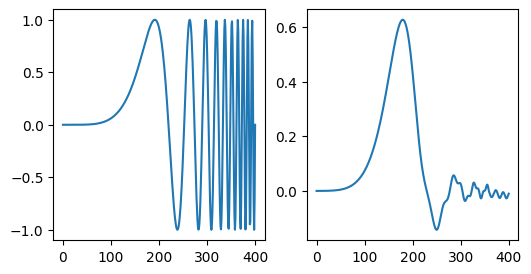

In [6]:
import torch
import math
from torch_cluster import radius_graph
from torch_scatter import scatter
eps = 1e-6

N = 400
baseweight = 100
r_edge = 1/math.sqrt(baseweight)+eps

baseweight = torch.tensor(baseweight, dtype = torch.float)

grid = torch.linspace(0,1,N+1)
# print(grid)
grid_weight = 1/(N+1)*torch.ones(N+1)
f_in = torch.sin(torch.linspace(0,1,N+1)**5*20*torch.pi)
# f_in = torch.ones(N+1)
batch = torch.zeros(N+1)

edge_src, edge_dst = radius_graph(grid, r_edge, batch, max_num_neighbors = N+1, loop=True) #shape: sum(k_n),1    k_n is the number of nth neighborhood pts


dist = grid[edge_src] - grid[edge_dst]  #shape: sum(k_n),1
print(dist.shape)
f_in_expand = f_in[edge_src]  #shape: sum(k_n),1
weight_expand = grid_weight[edge_src] #shape: sum(k_n),1

##### k(x,y) = exp(-w*(x-y)^2)
Gauss_edge = torch.sqrt(baseweight/torch.pi)*torch.exp(-baseweight*dist**2)  #shape: sum(k_n),1

# print(Gauss_edge)
prod = Gauss_edge * f_in_expand* weight_expand

f_out = scatter(prod,edge_dst)
# print(f_out)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(6, 3))
axs[0].plot(f_in)
axs[1].plot(f_out)



In [5]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter

N = 40000
r_edge = 0.05

grid = torch.linspace(0,1,N+1)

edge_src, edge_dst = radius_graph(grid, r_edge, max_num_neighbors = N+1,loop=True) #shape: sum(k_n),1    k_n is the number of nth neiborhood pts
print(edge_src.shape)

torch.Size([155998288])


# 1d test

In [81]:
import torch
import math
from torch_cluster import radius_graph
from torch_scatter import scatter
eps = 1e-6

device = 'cpu'
bsz = 8
N = 512 + 1
channel = 128
baseweight = 100000000
# r_edge = 1/math.sqrt(baseweight)+eps
r_edge = 0.05
max_num_neighbors = int(r_edge*N)+1
baseweight = torch.tensor(baseweight, dtype = torch.float, device = device)

grid = torch.linspace(0,1,N, device = device)
grid = grid.unsqueeze(0).repeat(bsz,1)  # bsz,N
grid_weight = 1/(N)*torch.ones_like(grid, device = device)
batch = torch.arange(bsz, device = device).unsqueeze(1).repeat(1,N)   # bsz,N

grid = grid.reshape(-1)  # bsz*N
grid_weight = grid_weight.reshape(-1)
batch = batch.reshape(-1)   # bsz*N
edge_src, edge_dst = radius_graph(grid, r_edge, batch, max_num_neighbors = max_num_neighbors, loop=True) 
#shape: sum(k_n)    k_n is the number of nth neighborhood pts

print(edge_src.shape, edge_dst.shape)

dist = grid[edge_src] - grid[edge_dst]  #shape: sum(k_n)
# print(dist.shape)


# f_in = torch.sin(torch.linspace(0,1,N)**5*20*torch.pi)
f_in = torch.ones(bsz, N+1, channel, device = device).reshape(-1,channel)
weight_expand = grid_weight[edge_src] #shape: sum(k_n)
f_in_expand = f_in[edge_src,:]  #shape: sum(k_n),channel

# ##### k(x,y) = exp(-w*(x-y)^2)
Gauss_edge = torch.sqrt(baseweight/torch.pi)*torch.exp(-baseweight*dist**2)  #shape: sum(k_n)

# # print(Gauss_edge)
src = Gauss_edge.unsqueeze(-1) * f_in_expand* weight_expand.unsqueeze(-1)
print(src.shape)
print(edge_dst.shape)
f_out = scatter(src, edge_dst, dim=0)
f_out = f_out.reshape(bsz,N,-1)
print(f_out.shape)

torch.Size([106704]) torch.Size([106704])
torch.Size([106704, 128])
torch.Size([106704])
torch.Size([8, 513, 128])


# 2d test

torch.Size([2210952]) torch.Size([2210952])
torch.Size([2210952])
torch.Size([8, 1681, 128])


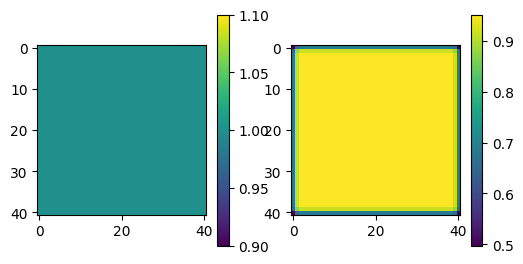

In [2]:
import torch
import math
from torch_cluster import radius_graph
from torch_scatter import scatter
eps = 1e-6

device = 'cpu'
bsz = 8
N = 40 + 1
channel = 128
baseweight = 1000

r_edge = 0.2
max_num_neighbors = int((2*r_edge*N)**2)+1
baseweight = torch.tensor(baseweight, dtype = torch.float, device = device)

x = torch.linspace(0, 1, N, device = device)
y = torch.linspace(0, 1, N, device = device)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid = torch.stack((X.flatten(), Y.flatten()), dim=1)  #N*N,2

grid = grid.unsqueeze(0).repeat(bsz,1,1)  # bsz,N*N,2
grid_weight = 1/(N*N)*torch.ones(bsz,N*N, device = device) # bsz,N*N
batch = torch.arange(bsz, device = device).reshape(bsz,1).repeat(1,N*N)   # bsz,N*N

grid = grid.reshape(-1,grid.shape[-1])  # bsz*N*N,2
grid_weight = grid_weight.reshape(-1)  # bsz*N*N
batch = batch.reshape(-1)   # bsz*N*N
edge_src, edge_dst = radius_graph(grid, r_edge, batch, max_num_neighbors = max_num_neighbors, loop=True) 
#shape: sum(k_n)    k_n is the number of nth neiborhood pts

# print(edge_src.shape, edge_dst.shape)

dist = torch.sqrt(torch.sum((grid[edge_src] - grid[edge_dst])**2,dim=1))  #shape: sum(k_n)
print(dist.shape)


# f_in = torch.sin(torch.linspace(0,1,N)**5*20*torch.pi)
f_in = torch.ones(bsz, N*N, channel, device = device)
weight_expand = grid_weight[edge_src] #shape: sum(k_n)
f_in_expand = f_in.reshape(-1,channel)[edge_src,:]  #shape: sum(k_n),channel

# ##### k(x,y) = exp(-w*(x-y)^2)
Gauss_edge = torch.sqrt((baseweight/torch.pi)**2)*torch.exp(-baseweight*dist**2)  #shape: sum(k_n)

# # print(Gauss_edge)
src = Gauss_edge.unsqueeze(-1) * f_in_expand* weight_expand.unsqueeze(-1)
# print(src.shape)
f_out = scatter(src, edge_dst, dim=0)
f_out = f_out.reshape(bsz,N*N,-1)
print(f_out.shape)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(6, 3))
im = axs[0].imshow(f_in[0,:,0].reshape(N,N).cpu())
fig.colorbar(im,ax=axs[0])
im = axs[1].imshow(f_out[0,:,0].reshape(N,N).cpu())
fig.colorbar(im,ax=axs[1])

# test model

In [3]:
import torch
import math
from torch_cluster import radius_graph
from torch_scatter import scatter
from timeit import default_timer
from Gaussconv import Gaussconv
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
def myradius_graph(grid,radius,device = 'cuda'):
    '''
    grid:  (bsz,N,phy_dim)

    radius:  float
    '''
    bsz,N,phy_dim = grid.shape
    max_num_neighbors = 2*int(N* (2*radius)**phy_dim)+1
    grid_expand = grid.reshape(-1)
    batch = torch.arange(bsz, device = device).reshape(bsz,1).repeat(1,N).reshape(-1)   # bsz,N
    edge_src, edge_dst = radius_graph(grid_expand, radius, batch, max_num_neighbors = max_num_neighbors, loop=True) 
    return edge_src.to(device), edge_dst.to(device)

in_channels = 16
out_channels = 16
bsz = 10
N = 5000
radius = 0.005
device = 'cuda'
init_weight = 100*torch.ones(out_channels,device = device)
model = Gaussconv(in_channels,out_channels,init_weight,device=device)
model = model.to(device)

x = torch.sin(torch.linspace(0,1,N,device = device)**4*10*torch.pi).reshape(1,N,1).expand(bsz,N,in_channels)
grid = torch.linspace(0,1,N,device = device).reshape(1,N,1).repeat(bsz,1,1)
grid_weight = 1/N*torch.ones(bsz,N).to(device)

t1 = default_timer()
edge_src, edge_dst = myradius_graph(grid,radius,device = device)
t2 = default_timer()
for _ in range(1000):
    T1 = default_timer()
    y = model(x,grid,grid_weight,edge_src, edge_dst)
    T2 = default_timer()
    print('graph one time: ',T2-T1)
t3 = default_timer()

print('graph time: ',t3-t2)
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(1,2, figsize=(6, 3))
# axs[0].plot(x[0,:,0].detach().cpu())
# axs[1].plot(y[0,:,0].detach().cpu())
# axs[0].set_title('input')
# axs[1].set_title('output')

graph one time:  0.05874220000259811
graph one time:  0.03868779999902472
graph one time:  0.014262000004237052
graph one time:  0.01578239999798825
graph one time:  0.014731000002939254
graph one time:  0.01479789999575587
graph one time:  0.015320899998187087
graph one time:  0.014387600000191014
graph one time:  0.015895299999101553
graph one time:  0.015404800004034769
graph one time:  0.01595390000147745
graph one time:  0.01569300000119256
graph one time:  0.015541200002189726
graph one time:  0.01509269999951357
graph one time:  0.015572000003885478
graph one time:  0.014704900000651833
graph one time:  0.014175199998135213
graph one time:  0.015054600000439677
graph one time:  0.01397980000183452
graph one time:  0.015916399999696296
graph one time:  0.015167300000030082
graph one time:  0.014957300001697149
graph one time:  0.014579000002413522
graph one time:  0.013810899996315129
graph one time:  0.01576529999874765
graph one time:  0.013778700005786959
graph one time:  0.01

In [5]:
import torch
from torch_scatter import scatter

src = torch.ones(5,2)

index = torch.tensor([[0],[1],[2],[0],[0]])
x = torch.zeros(50,2)
x = x.scatter_add_(0, index, src)
print(x)
print(x.shape)

tensor([[3., 0.],
        [1., 0.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
torch.Size([50, 2])
